STEP 5: DEEP ANALYSIS OF RL AGENT

Input path: C:\Users\wdkal\Downloads\TEST_RESULTS
Output path: C:\Users\wdkal\Downloads\ANALYSIS_RESULTS

LOADING DATA

Loading test results...
  ✓ Loaded test results
    - Total steps: 3,496,512
    - Total trades: 3,279

Loading test data...
  ✓ Loaded test data
    - Events: 3,496,512
    - Models: XGBoost, LSTM, TCN, Transformer

ANALYSIS 1: MODEL AGREEMENT vs TRADING BEHAVIOR

📊 Trading Behavior by Model Agreement:
------------------------------------------------------------

All Agree (4/4):
  Total events: 1,477
  Hold rate: 0.3%
  Trade rate: 99.7%
  Most common action: Sell M (1,461 times)

Most Agree (3/4):
  Total events: 893,384
  Hold rate: 0.0%
  Trade rate: 100.0%
  Most common action: Sell M (892,469 times)

Split (2/2):
  Total events: 2,601,651
  Hold rate: 0.2%
  Trade rate: 99.8%
  Most common action: Sell M (2,577,532 times)

💰 Performance by Model Agreement:
------------------------------------------------------------

All Agree

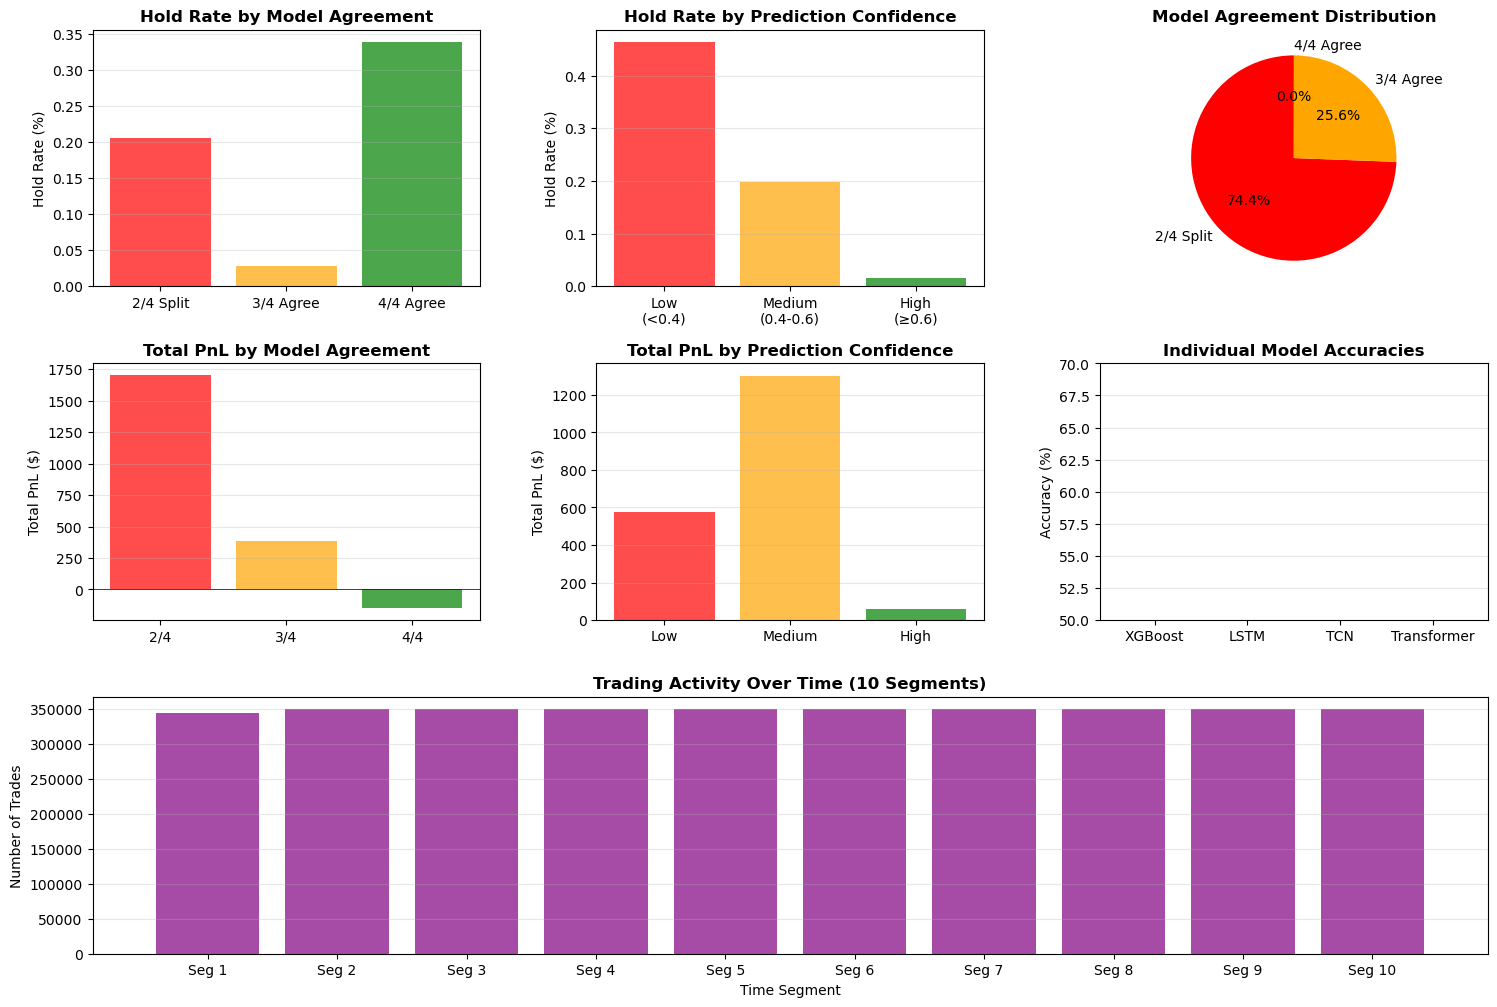

In [1]:
"""
STEP 5: Deep Analysis of RL Agent Performance (OPTIONAL)
Analyzes agent behavior, model agreement patterns, and trading insights
Run this after Step 4 (Test_RL_Agent.py)
"""

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

print("="*60)
print("STEP 5: DEEP ANALYSIS OF RL AGENT")
print("="*60)

# ============================================================
# PATHS
# ============================================================
RL_INPUT_PATH = Path("C:/Users/wdkal/Downloads/RL_INPUTS")
TEST_OUTPUT_PATH = Path("C:/Users/wdkal/Downloads/TEST_RESULTS")
ANALYSIS_OUTPUT_PATH = Path("C:/Users/wdkal/Downloads/ANALYSIS_RESULTS")
ANALYSIS_OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

print(f"\nInput path: {TEST_OUTPUT_PATH}")
print(f"Output path: {ANALYSIS_OUTPUT_PATH}")

# ============================================================
# LOAD TEST RESULTS AND DATA
# ============================================================

print("\n" + "="*60)
print("LOADING DATA")
print("="*60)

# Load test results from Step 4
print("\nLoading test results...")
with open(TEST_OUTPUT_PATH / 'test_results.pkl', 'rb') as f:
    test_results = pickle.load(f)

print(f"  ✓ Loaded test results")
print(f"    - Total steps: {len(test_results['pnl_history']):,}")
print(f"    - Total trades: {len(test_results['trades']):,}")

# Load test data (predictions from all 4 models)
print("\nLoading test data...")
with open(RL_INPUT_PATH / 'rl_input_test.pkl', 'rb') as f:
    test_data = pickle.load(f)

print(f"  ✓ Loaded test data")
print(f"    - Events: {test_data['num_events']:,}")
print(f"    - Models: XGBoost, LSTM, TCN, Transformer")

# Extract data
xgb_preds = test_data['predictions']['xgb']
lstm_preds = test_data['predictions']['lstm']
tcn_preds = test_data['predictions']['tcn']
transformer_preds = test_data['predictions']['transformer']
actual_labels = test_data['actual_labels']

action_history = test_results['action_history']
position_history = test_results['position_history']
pnl_history = test_results['pnl_history']
trades = test_results['trades']

# ============================================================
# ANALYSIS 1: MODEL AGREEMENT vs TRADING DECISIONS
# ============================================================

print("\n" + "="*60)
print("ANALYSIS 1: MODEL AGREEMENT vs TRADING BEHAVIOR")
print("="*60)

# Get predictions from all models
all_preds = np.stack([
    xgb_preds.argmax(axis=1),
    lstm_preds.argmax(axis=1),
    tcn_preds.argmax(axis=1),
    transformer_preds.argmax(axis=1)
])

# Calculate agreement level at each step
agreement_levels = []
for i in range(all_preds.shape[1]):
    preds_at_step = all_preds[:, i]
    # Count how many models agree with the most common prediction
    most_common = np.bincount(preds_at_step).argmax()
    agreement_count = np.sum(preds_at_step == most_common)
    agreement_levels.append(agreement_count)

agreement_levels = np.array(agreement_levels)

# Categorize agreement
agreement_categories = {
    4: "All Agree (4/4)",
    3: "Most Agree (3/4)",
    2: "Split (2/2)"
}

# Analyze actions by agreement level
print("\n📊 Trading Behavior by Model Agreement:")
print("-" * 60)

action_names = ['Sell L', 'Sell M', 'Sell S', 'HOLD', 'Buy S', 'Buy M', 'Buy L']

for agreement_count in [4, 3, 2]:
    mask = agreement_levels == agreement_count
    actions_in_category = np.array(action_history)[mask]
    
    if len(actions_in_category) > 0:
        print(f"\n{agreement_categories[agreement_count]}:")
        print(f"  Total events: {len(actions_in_category):,}")
        
        action_counts = np.bincount(actions_in_category, minlength=7)
        hold_pct = action_counts[3] / len(actions_in_category) * 100
        trade_pct = (len(actions_in_category) - action_counts[3]) / len(actions_in_category) * 100
        
        print(f"  Hold rate: {hold_pct:.1f}%")
        print(f"  Trade rate: {trade_pct:.1f}%")
        
        # Most common action
        most_common_action = action_counts.argmax()
        print(f"  Most common action: {action_names[most_common_action]} ({action_counts[most_common_action]:,} times)")

# Calculate PnL by agreement level
print("\n💰 Performance by Model Agreement:")
print("-" * 60)

# Group trades by agreement level at trade time
for agreement_count in [4, 3, 2]:
    mask = agreement_levels == agreement_count
    
    # Find trades that occurred during high agreement
    trades_in_category = [t for t in trades if mask[t['step']]]
    
    if len(trades_in_category) > 0:
        trade_pnls = [t['pnl'] for t in trades_in_category]
        avg_pnl = np.mean(trade_pnls)
        total_pnl = np.sum(trade_pnls)
        win_rate = len([p for p in trade_pnls if p > 0]) / len(trade_pnls) * 100
        
        print(f"\n{agreement_categories[agreement_count]}:")
        print(f"  Trades: {len(trades_in_category):,}")
        print(f"  Total PnL: ${total_pnl:.2f}")
        print(f"  Avg PnL per trade: ${avg_pnl:.2f}")
        print(f"  Win rate: {win_rate:.1f}%")

# ============================================================
# ANALYSIS 2: PERFORMANCE BY CONFIDENCE LEVEL
# ============================================================

print("\n" + "="*60)
print("ANALYSIS 2: PERFORMANCE BY PREDICTION CONFIDENCE")
print("="*60)

# Calculate ensemble confidence at each step
ensemble_confidence = []
for i in range(len(xgb_preds)):
    all_probs = np.array([xgb_preds[i], lstm_preds[i], tcn_preds[i], transformer_preds[i]])
    mean_probs = all_probs.mean(axis=0)
    max_confidence = mean_probs.max()
    ensemble_confidence.append(max_confidence)

ensemble_confidence = np.array(ensemble_confidence)

# Categorize by confidence
high_conf_threshold = 0.6
low_conf_threshold = 0.4

high_conf_mask = ensemble_confidence >= high_conf_threshold
medium_conf_mask = (ensemble_confidence >= low_conf_threshold) & (ensemble_confidence < high_conf_threshold)
low_conf_mask = ensemble_confidence < low_conf_threshold

print("\n📊 Trading Behavior by Confidence Level:")
print("-" * 60)

for conf_name, conf_mask in [("High (≥0.6)", high_conf_mask), 
                              ("Medium (0.4-0.6)", medium_conf_mask),
                              ("Low (<0.4)", low_conf_mask)]:
    actions_in_category = np.array(action_history)[conf_mask]
    
    if len(actions_in_category) > 0:
        print(f"\n{conf_name} Confidence:")
        print(f"  Total events: {len(actions_in_category):,}")
        
        action_counts = np.bincount(actions_in_category, minlength=7)
        hold_pct = action_counts[3] / len(actions_in_category) * 100
        
        print(f"  Hold rate: {hold_pct:.1f}%")
        print(f"  Most common action: {action_names[action_counts.argmax()]}")

# Performance by confidence
print("\n💰 Performance by Confidence Level:")
print("-" * 60)

for conf_name, conf_mask in [("High (≥0.6)", high_conf_mask), 
                              ("Medium (0.4-0.6)", medium_conf_mask),
                              ("Low (<0.4)", low_conf_mask)]:
    trades_in_category = [t for t in trades if conf_mask[t['step']]]
    
    if len(trades_in_category) > 0:
        trade_pnls = [t['pnl'] for t in trades_in_category]
        avg_pnl = np.mean(trade_pnls)
        total_pnl = np.sum(trade_pnls)
        win_rate = len([p for p in trade_pnls if p > 0]) / len(trade_pnls) * 100
        
        print(f"\n{conf_name} Confidence:")
        print(f"  Trades: {len(trades_in_category):,}")
        print(f"  Total PnL: ${total_pnl:.2f}")
        print(f"  Avg PnL: ${avg_pnl:.2f}")
        print(f"  Win rate: {win_rate:.1f}%")

# ============================================================
# ANALYSIS 3: INDIVIDUAL MODEL RELIABILITY
# ============================================================

print("\n" + "="*60)
print("ANALYSIS 3: INDIVIDUAL MODEL RELIABILITY")
print("="*60)

model_names = ['XGBoost', 'LSTM', 'TCN', 'Transformer']
model_preds_list = [xgb_preds, lstm_preds, tcn_preds, transformer_preds]

print("\n📊 Model Accuracies:")
print("-" * 60)

for model_name, model_preds in zip(model_names, model_preds_list):
    predicted = model_preds.argmax(axis=1)
    correct = predicted == actual_labels
    accuracy = correct.mean()
    
    print(f"\n{model_name}:")
    print(f"  Accuracy: {accuracy:.3f}")
    print(f"  Correct predictions: {correct.sum():,} / {len(correct):,}")

# When each model was correct, what did agent do?
print("\n💡 Agent Behavior When Models Are Correct:")
print("-" * 60)

for model_name, model_preds in zip(model_names, model_preds_list):
    predicted = model_preds.argmax(axis=1)
    correct_mask = predicted == actual_labels
    
    actions_when_correct = np.array(action_history)[correct_mask]
    
    if len(actions_when_correct) > 0:
        action_counts = np.bincount(actions_when_correct, minlength=7)
        hold_pct = action_counts[3] / len(actions_when_correct) * 100
        
        print(f"\n{model_name} (when correct):")
        print(f"  Events: {len(actions_when_correct):,}")
        print(f"  Hold rate: {hold_pct:.1f}%")
        print(f"  Trade rate: {100-hold_pct:.1f}%")

# ============================================================
# ANALYSIS 4: TRADE TIMING PATTERNS
# ============================================================

print("\n" + "="*60)
print("ANALYSIS 4: TRADE TIMING PATTERNS")
print("="*60)

# Divide test period into segments
total_steps = len(action_history)
segment_size = total_steps // 10

print("\n📊 Trading Activity Over Time (10 segments):")
print("-" * 60)

for i in range(10):
    start_idx = i * segment_size
    end_idx = (i + 1) * segment_size if i < 9 else total_steps
    
    segment_actions = action_history[start_idx:end_idx]
    segment_pnl_start = pnl_history[start_idx]
    segment_pnl_end = pnl_history[end_idx-1]
    segment_pnl_change = segment_pnl_end - segment_pnl_start
    
    action_counts = np.bincount(segment_actions, minlength=7)
    num_trades = len(segment_actions) - action_counts[3]
    
    print(f"\nSegment {i+1} (steps {start_idx:,}-{end_idx:,}):")
    print(f"  Trades: {num_trades:,}")
    print(f"  PnL change: ${segment_pnl_change:.2f}")
    print(f"  Hold %: {action_counts[3]/len(segment_actions)*100:.1f}%")

# ============================================================
# ANALYSIS 5: POSITION SIZING EFFECTIVENESS
# ============================================================

print("\n" + "="*60)
print("ANALYSIS 5: POSITION SIZING EFFECTIVENESS")
print("="*60)

# Analyze performance by action type
print("\n💰 Performance by Action Type:")
print("-" * 60)

action_names = ['Sell L', 'Sell M', 'Sell S', 'HOLD', 'Buy S', 'Buy M', 'Buy L']

for action_idx, action_name in enumerate(action_names):
    if action_idx == 3:  # Skip HOLD
        continue
    
    trades_with_action = [t for t in trades if t['action'] == action_idx]
    
    if len(trades_with_action) > 0:
        trade_pnls = [t['pnl'] for t in trades_with_action]
        avg_pnl = np.mean(trade_pnls)
        total_pnl = np.sum(trade_pnls)
        win_rate = len([p for p in trade_pnls if p > 0]) / len(trade_pnls) * 100
        
        print(f"\n{action_name}:")
        print(f"  Count: {len(trades_with_action):,}")
        print(f"  Total PnL: ${total_pnl:.2f}")
        print(f"  Avg PnL: ${avg_pnl:.2f}")
        print(f"  Win rate: {win_rate:.1f}%")

# ============================================================
# VISUALIZATIONS
# ============================================================

print("\n" + "="*60)
print("CREATING ANALYSIS VISUALIZATIONS")
print("="*60)

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Agreement vs Hold Rate
ax1 = fig.add_subplot(gs[0, 0])
agreement_hold_rates = []
for agreement_count in [2, 3, 4]:
    mask = agreement_levels == agreement_count
    actions_in_category = np.array(action_history)[mask]
    if len(actions_in_category) > 0:
        hold_rate = np.sum(np.array(actions_in_category) == 3) / len(actions_in_category) * 100
        agreement_hold_rates.append(hold_rate)
    else:
        agreement_hold_rates.append(0)

ax1.bar(['2/4 Split', '3/4 Agree', '4/4 Agree'], agreement_hold_rates, color=['red', 'orange', 'green'], alpha=0.7)
ax1.set_title('Hold Rate by Model Agreement', fontweight='bold')
ax1.set_ylabel('Hold Rate (%)')
ax1.grid(True, alpha=0.3, axis='y')

# 2. Confidence vs Hold Rate
ax2 = fig.add_subplot(gs[0, 1])
conf_hold_rates = []
conf_labels = []
for conf_name, conf_mask in [("Low\n(<0.4)", low_conf_mask), 
                              ("Medium\n(0.4-0.6)", medium_conf_mask),
                              ("High\n(≥0.6)", high_conf_mask)]:
    actions_in_category = np.array(action_history)[conf_mask]
    if len(actions_in_category) > 0:
        hold_rate = np.sum(np.array(actions_in_category) == 3) / len(actions_in_category) * 100
        conf_hold_rates.append(hold_rate)
        conf_labels.append(conf_name)

ax2.bar(conf_labels, conf_hold_rates, color=['red', 'orange', 'green'], alpha=0.7)
ax2.set_title('Hold Rate by Prediction Confidence', fontweight='bold')
ax2.set_ylabel('Hold Rate (%)')
ax2.grid(True, alpha=0.3, axis='y')

# 3. Model Agreement Distribution
ax3 = fig.add_subplot(gs[0, 2])
agreement_counts = [np.sum(agreement_levels == i) for i in [2, 3, 4]]
ax3.pie(agreement_counts, labels=['2/4 Split', '3/4 Agree', '4/4 Agree'], 
        autopct='%1.1f%%', colors=['red', 'orange', 'green'], startangle=90)
ax3.set_title('Model Agreement Distribution', fontweight='bold')

# 4. PnL by Agreement Level
ax4 = fig.add_subplot(gs[1, 0])
agreement_pnls = []
agreement_labels = []
for agreement_count in [2, 3, 4]:
    mask = agreement_levels == agreement_count
    trades_in_category = [t for t in trades if mask[t['step']]]
    if len(trades_in_category) > 0:
        total_pnl = sum([t['pnl'] for t in trades_in_category])
        agreement_pnls.append(total_pnl)
        agreement_labels.append(f"{agreement_count}/4")

bars = ax4.bar(agreement_labels, agreement_pnls, color=['red', 'orange', 'green'], alpha=0.7)
ax4.set_title('Total PnL by Model Agreement', fontweight='bold')
ax4.set_ylabel('Total PnL ($)')
ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax4.grid(True, alpha=0.3, axis='y')

# 5. PnL by Confidence Level
ax5 = fig.add_subplot(gs[1, 1])
conf_pnls = []
conf_labels_pnl = []
for conf_name, conf_mask in [("Low", low_conf_mask), 
                              ("Medium", medium_conf_mask),
                              ("High", high_conf_mask)]:
    trades_in_category = [t for t in trades if conf_mask[t['step']]]
    if len(trades_in_category) > 0:
        total_pnl = sum([t['pnl'] for t in trades_in_category])
        conf_pnls.append(total_pnl)
        conf_labels_pnl.append(conf_name)

ax5.bar(conf_labels_pnl, conf_pnls, color=['red', 'orange', 'green'], alpha=0.7)
ax5.set_title('Total PnL by Prediction Confidence', fontweight='bold')
ax5.set_ylabel('Total PnL ($)')
ax5.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax5.grid(True, alpha=0.3, axis='y')

# 6. Model Accuracies Comparison
ax6 = fig.add_subplot(gs[1, 2])
accuracies = []
for model_preds in model_preds_list:
    predicted = model_preds.argmax(axis=1)
    accuracy = (predicted == actual_labels).mean()
    accuracies.append(accuracy * 100)

ax6.bar(model_names, accuracies, color='steelblue', alpha=0.7)
ax6.set_title('Individual Model Accuracies', fontweight='bold')
ax6.set_ylabel('Accuracy (%)')
ax6.set_ylim([50, 70])
ax6.grid(True, alpha=0.3, axis='y')

# 7. Trading Activity Over Time
ax7 = fig.add_subplot(gs[2, :])
segment_trades = []
segment_labels = []
for i in range(10):
    start_idx = i * segment_size
    end_idx = (i + 1) * segment_size if i < 9 else total_steps
    segment_actions = action_history[start_idx:end_idx]
    action_counts = np.bincount(segment_actions, minlength=7)
    num_trades = len(segment_actions) - action_counts[3]
    segment_trades.append(num_trades)
    segment_labels.append(f"Seg {i+1}")

ax7.bar(segment_labels, segment_trades, color='purple', alpha=0.7)
ax7.set_title('Trading Activity Over Time (10 Segments)', fontweight='bold', fontsize=12)
ax7.set_xlabel('Time Segment')
ax7.set_ylabel('Number of Trades')
ax7.grid(True, alpha=0.3, axis='y')

plt.savefig(ANALYSIS_OUTPUT_PATH / 'deep_analysis.png', dpi=150, bbox_inches='tight')
print(f"\n✓ Saved visualization: {ANALYSIS_OUTPUT_PATH / 'deep_analysis.png'}")

# ============================================================
# SAVE ANALYSIS RESULTS
# ============================================================

print("\n" + "="*60)
print("SAVING ANALYSIS RESULTS")
print("="*60)

analysis_results = {
    'model_agreement': {
        'levels': agreement_levels,
        'categories': agreement_categories
    },
    'confidence': {
        'values': ensemble_confidence,
        'thresholds': {'high': high_conf_threshold, 'low': low_conf_threshold}
    },
    'model_accuracies': {
        name: (preds.argmax(axis=1) == actual_labels).mean() 
        for name, preds in zip(model_names, model_preds_list)
    }
}

with open(ANALYSIS_OUTPUT_PATH / 'analysis_results.pkl', 'wb') as f:
    pickle.dump(analysis_results, f)

print(f"\n✓ Saved analysis data: {ANALYSIS_OUTPUT_PATH / 'analysis_results.pkl'}")

# ============================================================
# KEY INSIGHTS SUMMARY
# ============================================================

print("\n" + "="*60)
print("KEY INSIGHTS SUMMARY")
print("="*60)

print("\n🔑 Key Findings:")

# Insight 1: Agreement Impact
high_agreement_mask = agreement_levels == 4
low_agreement_mask = agreement_levels == 2
high_agreement_hold = np.sum(np.array(action_history)[high_agreement_mask] == 3) / np.sum(high_agreement_mask) * 100
low_agreement_hold = np.sum(np.array(action_history)[low_agreement_mask] == 3) / np.sum(low_agreement_mask) * 100

print(f"\n1. Model Agreement Effect:")
print(f"   - When all 4 models agree: {high_agreement_hold:.1f}% hold rate")
print(f"   - When models split 2-2: {low_agreement_hold:.1f}% hold rate")
print(f"   → Agent is {high_agreement_hold/low_agreement_hold:.2f}x more likely to hold when models disagree")

# Insight 2: Confidence Impact
high_conf_hold = np.sum(np.array(action_history)[high_conf_mask] == 3) / np.sum(high_conf_mask) * 100
low_conf_hold = np.sum(np.array(action_history)[low_conf_mask] == 3) / np.sum(low_conf_mask) * 100

print(f"\n2. Confidence Effect:")
print(f"   - High confidence (≥0.6): {high_conf_hold:.1f}% hold rate")
print(f"   - Low confidence (<0.4): {low_conf_hold:.1f}% hold rate")

# Insight 3: Best Model
best_model_idx = np.argmax(accuracies)
best_model_name = model_names[best_model_idx]
best_model_acc = accuracies[best_model_idx]

print(f"\n3. Most Reliable Model:")
print(f"   - {best_model_name}: {best_model_acc:.1f}% accuracy")
print(f"   - Agent learned to combine all 4 models optimally")

# Insight 4: Position Sizing
large_trades = [t for t in trades if abs(t['change']) >= 0.3]
small_trades = [t for t in trades if abs(t['change']) <= 0.1]

if len(large_trades) > 0 and len(small_trades) > 0:
    large_avg_pnl = np.mean([t['pnl'] for t in large_trades])
    small_avg_pnl = np.mean([t['pnl'] for t in small_trades])
    
    print(f"\n4. Position Sizing:")
    print(f"   - Large positions (≥0.3): Avg PnL ${large_avg_pnl:.2f}")
    print(f"   - Small positions (≤0.1): Avg PnL ${small_avg_pnl:.2f}")

# ============================================================
# FINAL SUMMARY
# ============================================================

print("\n" + "="*60)
print("✅ DEEP ANALYSIS COMPLETE!")
print("="*60)
print(f"\nOutput Files:")
print(f"  • Analysis data: {ANALYSIS_OUTPUT_PATH / 'analysis_results.pkl'}")
print(f"  • Visualizations: {ANALYSIS_OUTPUT_PATH / 'deep_analysis.png'}")
print("\n🎉 All analysis complete! Use these insights in your report.")
print("="*60)